In [1]:
import json
from flatten_json import flatten
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')


In [2]:
def calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe):
    team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Shot'))
    team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Goal'))
    shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
    goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

    total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
    total_goals = goals_from_filtered_dataframe.shape[0]
    goal_conversion_ratio = (total_goals / total_attempts) * 100 
    print('The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, round(goal_conversion_ratio,2)))
    return (shots_from_filtered_dataframe, goals_from_filtered_dataframe)


In [3]:
with open('data/shots_goals_data.json', 'r') as f:
    data = json.load(f)
record_flattened = [flatten(record) for record in data]
shot_goals_dataframe_from_json = pd.DataFrame(record_flattened)
display(shot_goals_dataframe_from_json.head())

coor_x  coor_y event_type  coor_x_normalized  coor_y_normalized  \
0    85.0    -1.0       Goal               85.0               -1.0   
1   -32.0    -2.0       Shot               32.0                2.0   
2    63.0    -6.0       Shot               63.0               -6.0   
3   -59.0   -20.0       Shot               59.0               20.0   
4   -42.0   -29.0       Shot               42.0               29.0   

      game_id        shooting_team shooting_team_home_or_away  \
0  2019020001      Ottawa Senators                       Away   
1  2019020001  Toronto Maple Leafs                       Home   
2  2019020001      Ottawa Senators                       Away   
3  2019020001  Toronto Maple Leafs                       Home   
4  2019020001  Toronto Maple Leafs                       Home   

  shot_goal_defending_team  
0      Toronto Maple Leafs  
1          Ottawa Senators  
2      Toronto Maple Leafs  
3          Ottawa Senators  
4          Ottawa Senators

In [4]:
def display_dataset(team_a, team_b, shot_goals_dataframe):
    # find all the records where these teams have played
    condition = ((shot_goals_dataframe['shooting_team'] == team_a) & 
                 (shot_goals_dataframe['shot_goal_defending_team'] == team_b)) | ((shot_goals_dataframe['shooting_team'] == team_b) & 
                (shot_goals_dataframe['shot_goal_defending_team'] == team_a))
    filtered_dataframe = shot_goals_dataframe[condition]
    filtered_dataframe.head()
    return filtered_dataframe

## Goal Conversion Ratio

In [5]:
def calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe):
    team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Shot'))
    team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Goal'))
    shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
    goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

    total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
    total_goals = goals_from_filtered_dataframe.shape[0]
    goal_conversion_ratio = (total_goals / total_attempts) * 100 
    print('The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, round(goal_conversion_ratio,2)))
    return (shots_from_filtered_dataframe, goals_from_filtered_dataframe)

## Find Hexbins for shots and goals

In [6]:
def plot_hexbin_shots_goals(shots_from_filtered_dataframe, goals_from_filtered_dataframe):
    rink_size = [0, 100.0, -42.5, 42.5]
    if shots_from_filtered_dataframe is not None:
        #plotting shots
        shots_x_coordinates = shots_from_filtered_dataframe['coor_x_normalized'].to_numpy()
        shots_y_coordinates = shots_from_filtered_dataframe['coor_y_normalized'].to_numpy()
        #creating a hexbin plot to find the density of the attempted shots
        figure = plt.figure()
        shots_hexbin_plot =  plt.hexbin(shots_x_coordinates, shots_y_coordinates, gridsize=40, extent=rink_size);
        #finding the centres of each hexbin 
        shots_hexbin_offsets = shots_hexbin_plot.get_offsets();
        #finding the values of the hexagons
        shots_hexbin_values = shots_hexbin_plot.get_array();
        plt.show()
        plt.clf()
    #plotting goals
    goals_x_coordinates = goals_from_filtered_dataframe['coor_x_normalized'].to_numpy()
    goals_y_coordinates = goals_from_filtered_dataframe['coor_y_normalized'].to_numpy()
    figure = plt.figure()
    goals_hexbin_plot =  plt.hexbin(goals_x_coordinates, goals_y_coordinates, gridsize=40, extent=rink_size);
    goals_hexbin_offsets = goals_hexbin_plot.get_offsets()
    goals_hexbin_values = goals_hexbin_plot.get_array();
    if shots_from_filtered_dataframe is not None:
        return (shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)
    else:
        return (goals_hexbin_offsets, goals_hexbin_values)


## Plot shots on Rink

In [7]:
def plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values, plot_shots = True):
    if plot_shots == True:
        rink_image = Image.open('assets/NHL-Rink-Half.jpeg')
        figure = plt.figure(figsize = (12, 15))
        figure_subplot_1 = figure.add_subplot(1, 1, 1)
        figure_subplot_1.set_ylim(ymin = -42.5, ymax = 42.5)
        figure_subplot_1.set_xlim(xmin = 0.0, xmax = 100)
        rink_image_for_shots = figure_subplot_1.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')
        for counter, vertex in enumerate(shots_hexbin_offsets):
            if shots_hexbin_values[counter] > 1:
                continue       
            shots_hexbin_value_scaled = shots_hexbin_values[counter] / max(shots_hexbin_values)
            hex_radius = 3 * math.sqrt(shots_hexbin_value_scaled)
            shot_hexagon = RegularPolygon((vertex[0],vertex[1]), numVertices = 3, radius=hex_radius, 
                            orientation=np.radians(-90), alpha=0.6, edgecolor='darkslategrey', color = 'darkslategrey')
            figure_subplot_1.add_patch(shot_hexagon)
        figure_subplot_1.set_xticks([])
        figure_subplot_1.set_yticks([])
        figure_subplot_1.figure.savefig('Attack_Shots.jpeg', bbox_inches='tight')
    
    figure = plt.figure(figsize = (12, 15))
    rink_image = Image.open('assets/NHL-Rink-Half.jpeg')
    figure_subplot_2 = figure.add_subplot(1, 1, 1)
    figure_subplot_2.set_ylim(ymin = -42.5, ymax = 42.5)
    figure_subplot_2.set_xlim(xmin = 0.0, xmax = 100)
    rink_image_for_goals = figure_subplot_2.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')
    for counter, vertex in enumerate(goals_hexbin_offsets):
        if goals_hexbin_values[counter] < 1:
            continue
        goals_hexbin_value_scaled = goals_hexbin_values[counter] / max(goals_hexbin_values)
        hex_radius = 3 * math.sqrt(goals_hexbin_value_scaled)
        goal_hexagon = RegularPolygon((vertex[0], vertex[1]), numVertices = 6, radius = hex_radius, 
                        orientation = np.radians(-90), alpha = 0.5, edgecolor = 'Black', color = 'darkgreen')
        figure_subplot_2.add_patch(goal_hexagon)
    figure_subplot_2.set_xticks([])
    figure_subplot_2.set_yticks([])
    figure_subplot_2.figure.savefig('Attack_Goals.jpeg', bbox_inches='tight')
    
    

In [8]:
def plot_shots_and_goals_comparison(shots_filename, goals_filename, plot_title_shots, plot_title_goals, plot_shots = True):
    figure = plt.figure(figsize = (20, 10))
    goals_subplot = None
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    if plot_shots == True:
        shots = Image.open(shots_filename).rotate(90, expand = 1)
        shots_subplot = figure.add_subplot(1, 2, 1)
        shots_subplot.set_title(plot_title_shots, fontsize=18)
        shots_subplot.set_ylabel('Direction of Play ⟶', fontsize = 18)
        shots_subplot.set_xticks([])
        shots_subplot.set_yticks([])
        # if shots are plotted then plot in the next column
        # else show in the first row first column
        shots_subplot.imshow(shots)
        goals_subplot = figure.add_subplot(1, 2, 2)
    else:
        goals_subplot = figure.add_subplot(1, 1, 1)
    goals = Image.open(goals_filename).rotate(90, expand = 1)
    goals_subplot.set_title(plot_title_goals, fontsize=18)
    goals_subplot.set_ylabel('Direction of Play ⟶', fontsize = 18)
    goals_subplot.set_xticks([])
    goals_subplot.set_yticks([])
    goals_subplot.imshow(goals)
    plt.show()

## Attacking Positions

The goal conversion ratio of 'Toronto Maple Leafs' against 'Ottawa Senators' is 10.44%


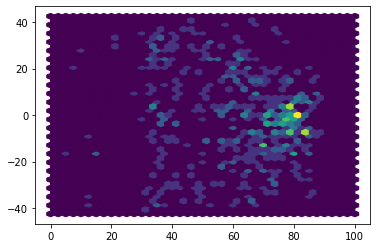

<Figure size 432x288 with 0 Axes>

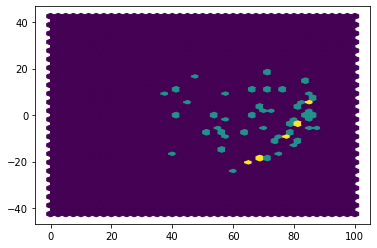

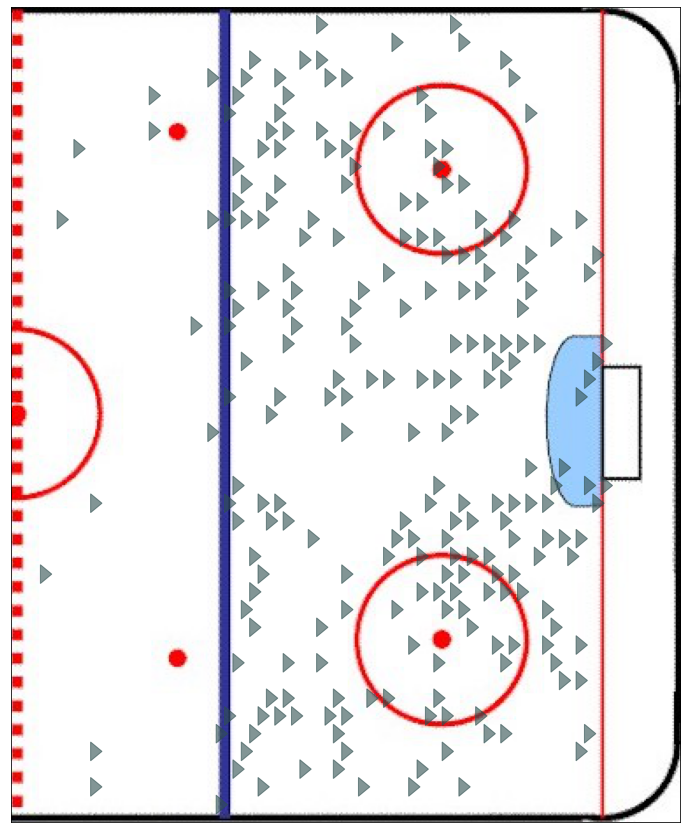

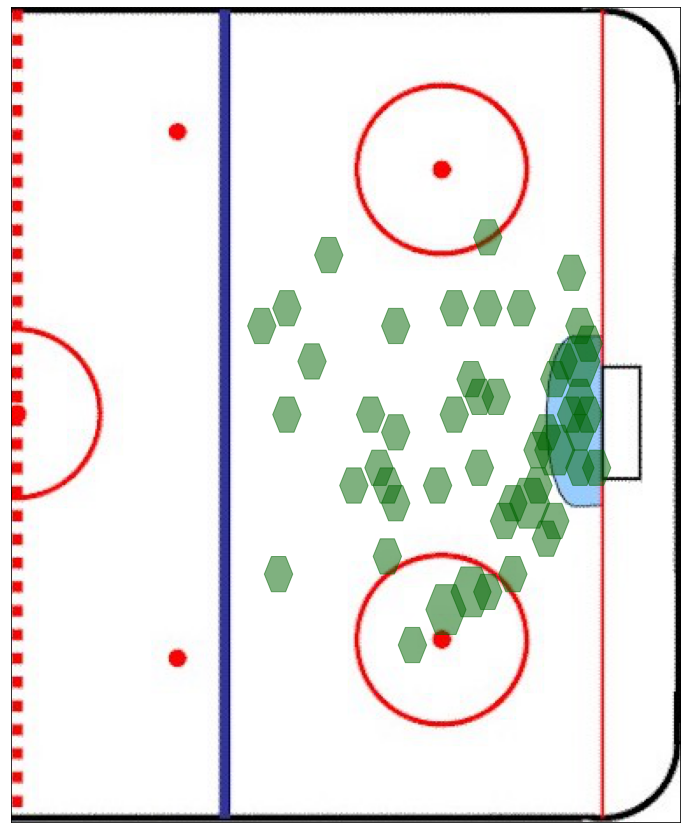

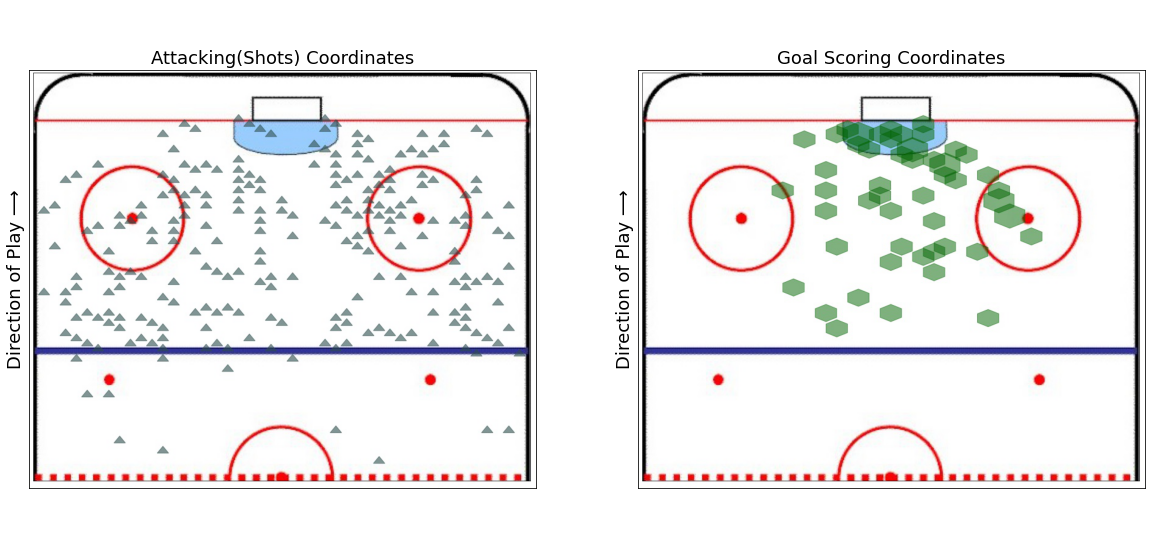

In [9]:
team_a = "Toronto Maple Leafs" 
team_b = "Ottawa Senators"
filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe_from_json)
shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio(team_a, \
                                                                                               team_b, \
                                                                                               filtered_dataframe)

shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(shots_from_filtered_dataframe, \
                                                                                                               goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)

plot_shots_and_goals_comparison(shots_filename = 'Attack_Shots.jpeg', \
                                goals_filename = 'Attack_Goals.jpeg', \
                                plot_title_shots = 'Attacking(Shots) Coordinates', \
                                plot_title_goals = 'Goal Scoring Coordinates' \
                               )

## Defence Positions

The goal conversion ratio of 'Ottawa Senators' against 'Toronto Maple Leafs' is 10.1%


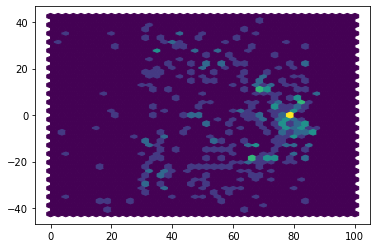

<Figure size 432x288 with 0 Axes>

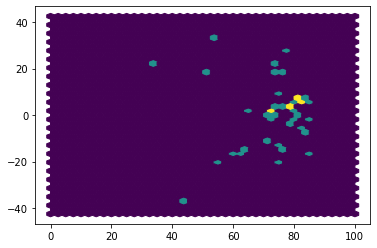

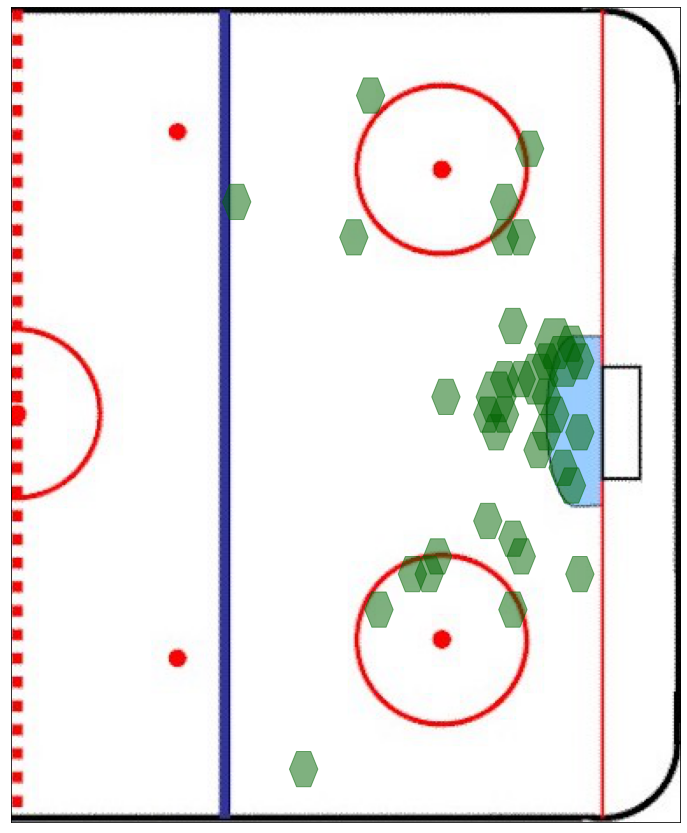

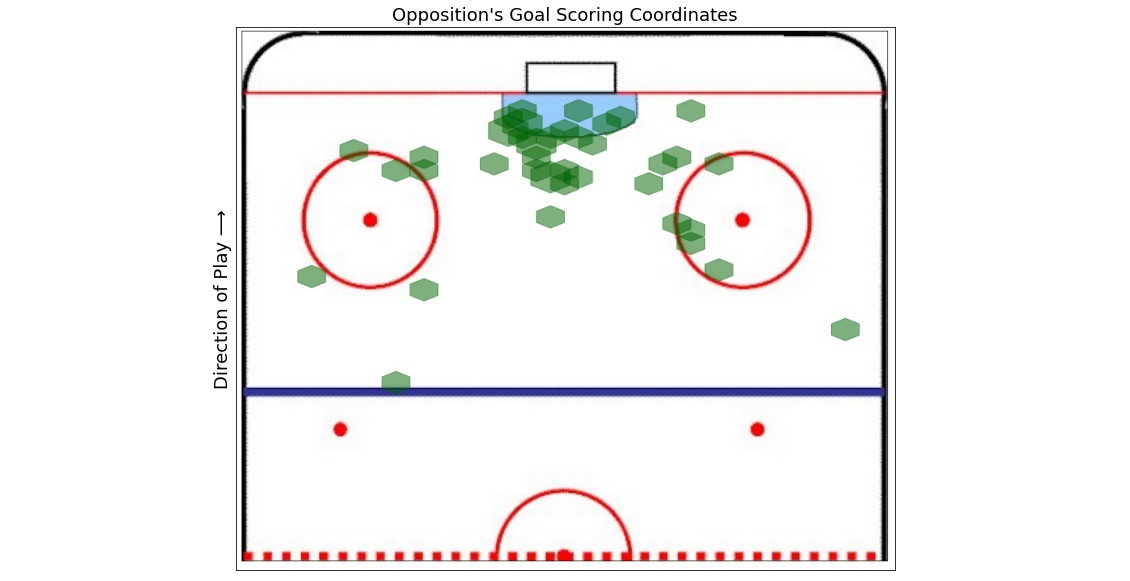

In [10]:
team_b, team_a = team_a, team_b
filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe_from_json)
shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe)
shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(shots_from_filtered_dataframe, goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values, False)

plot_shots_and_goals_comparison('Attack_Shots.jpeg', 'Attack_Goals.jpeg', \
                                plot_title_shots = '', \
                                plot_title_goals = 'Opposition\'s Goal Scoring Coordinates', \
                                plot_shots = False
                               )

## Player statistics for top 4 players

In [11]:
%store -r top_4_players
top_4_players

['Connor McDavid', 'Nikita Kucherov', 'Sidney Crosby', 'Nathan MacKinnon']

In [12]:
connor_mcdavid_goals = pd.read_csv(r'data/Connor McDavid.csv')
nikita_kucherov_goals = pd.read_csv(r'data/Nikita Kucherov.csv')
sidney_crosby_goals = pd.read_csv(r'data/Sidney Crosby.csv')
nathan_mackinnon_goals = pd.read_csv(r'data/Nathan MacKinnon.csv')
player_df_list = []
player_df_list.append(connor_mcdavid_goals)
player_df_list.append(nikita_kucherov_goals)
player_df_list.append(sidney_crosby_goals)
player_df_list.append(nathan_mackinnon_goals)

<Figure size 432x288 with 0 Axes>

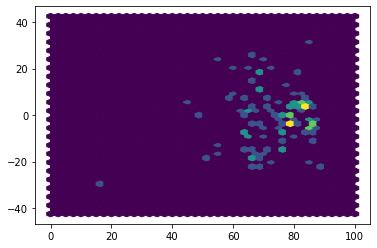

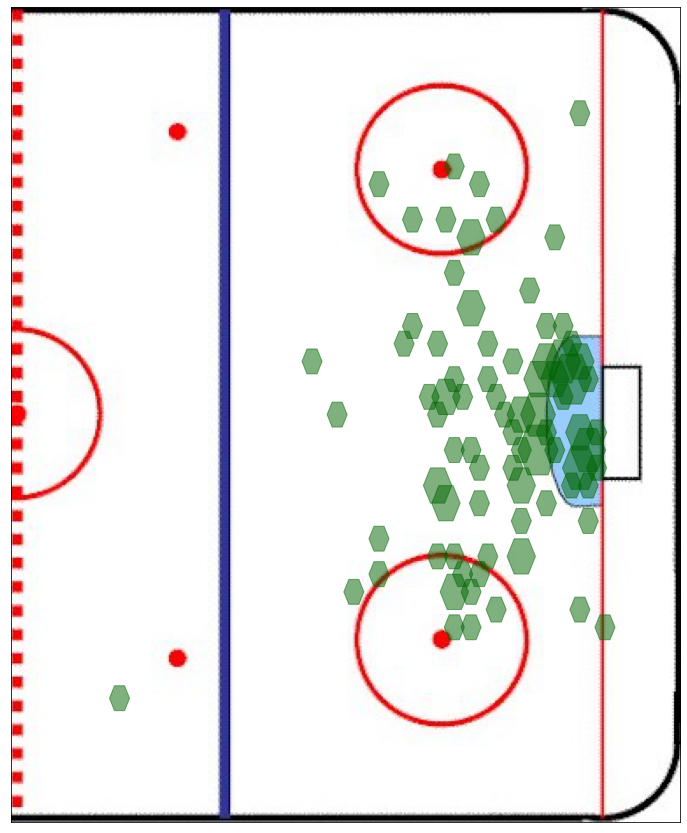

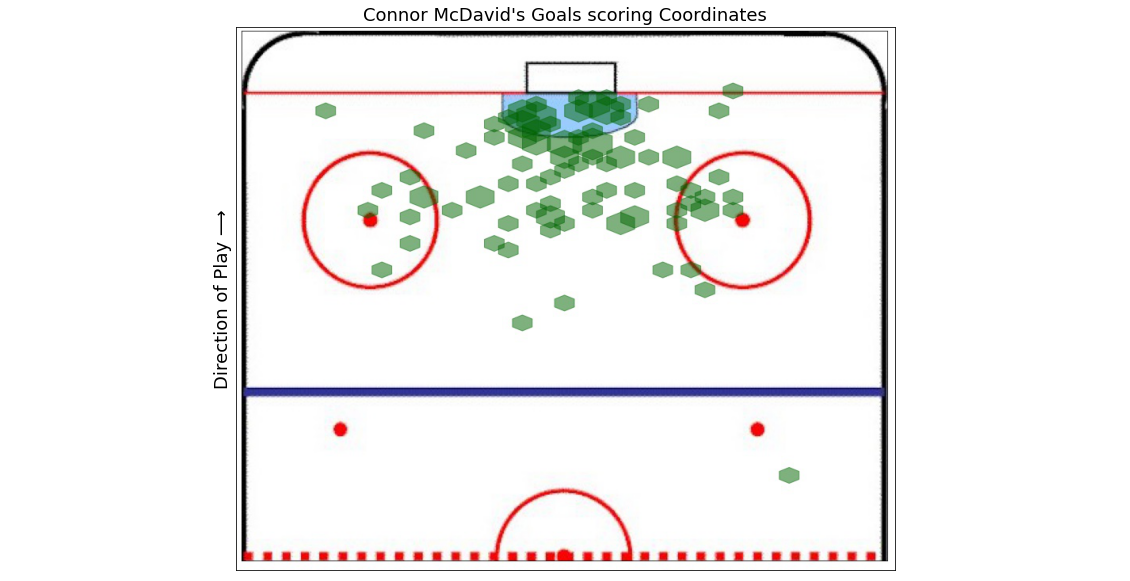

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

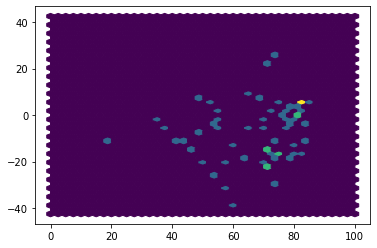

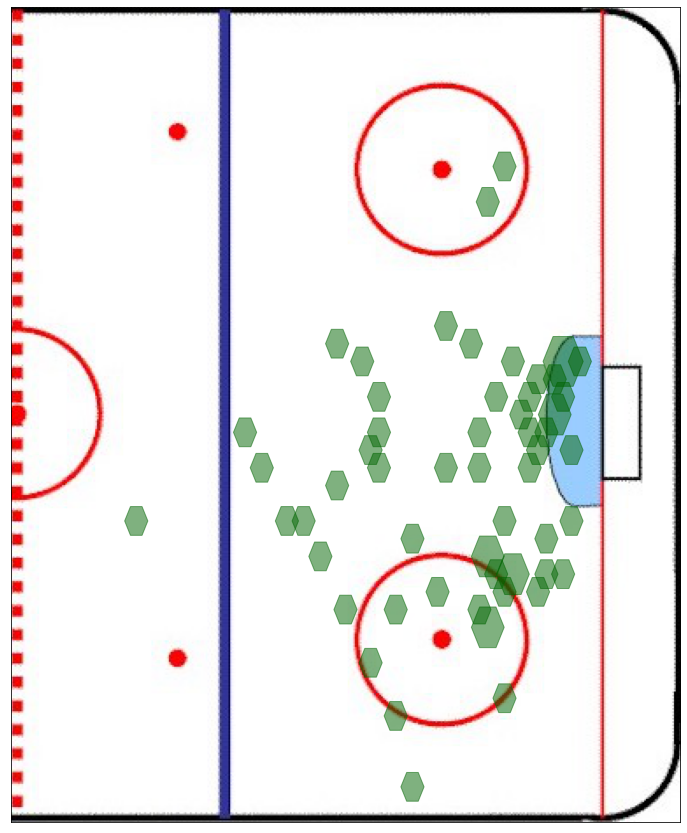

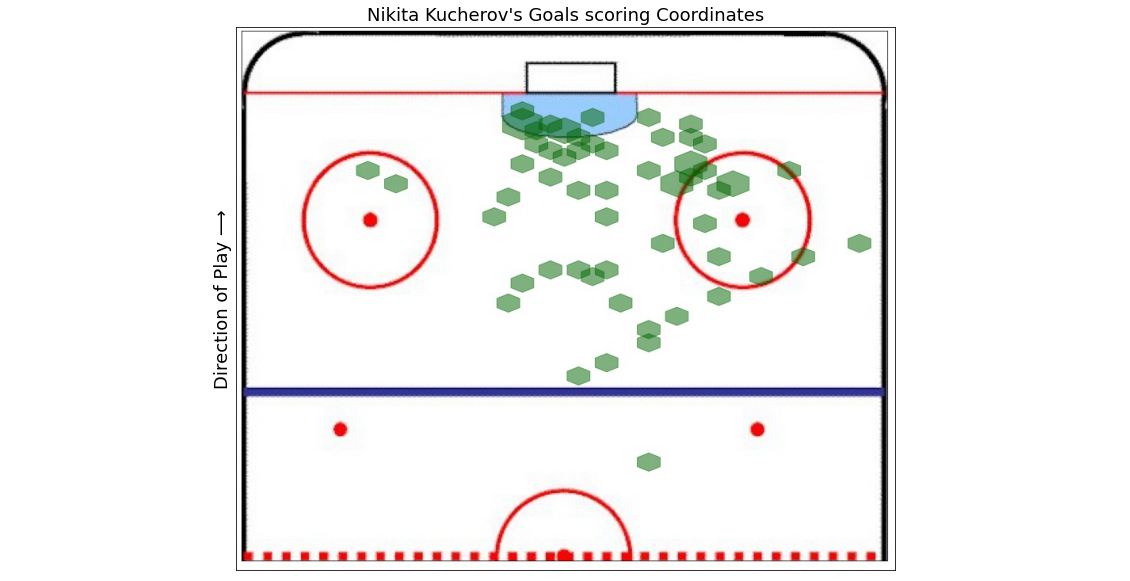

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

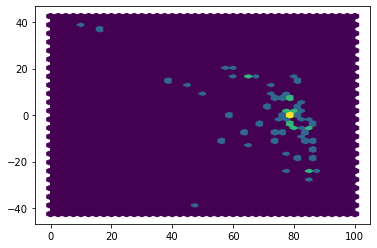

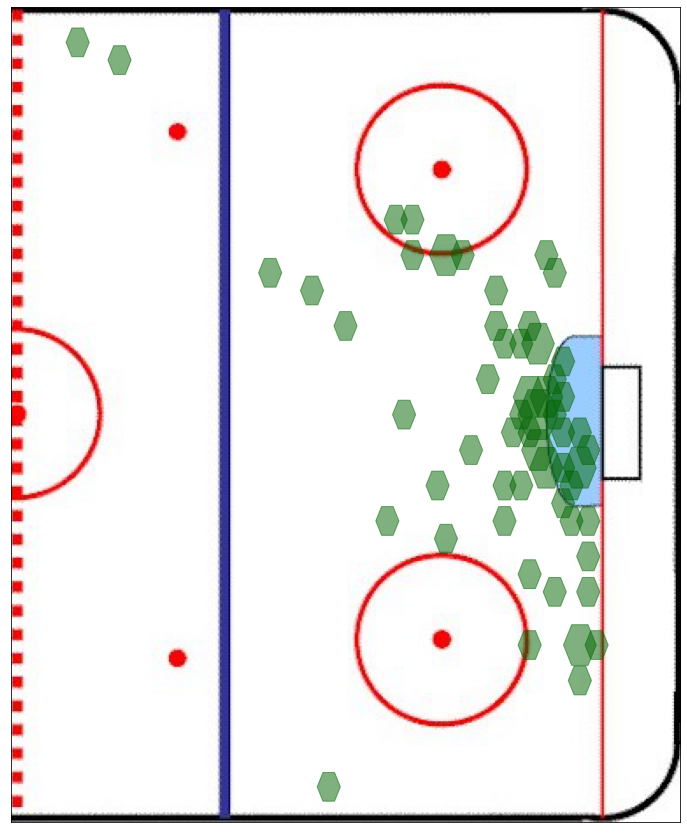

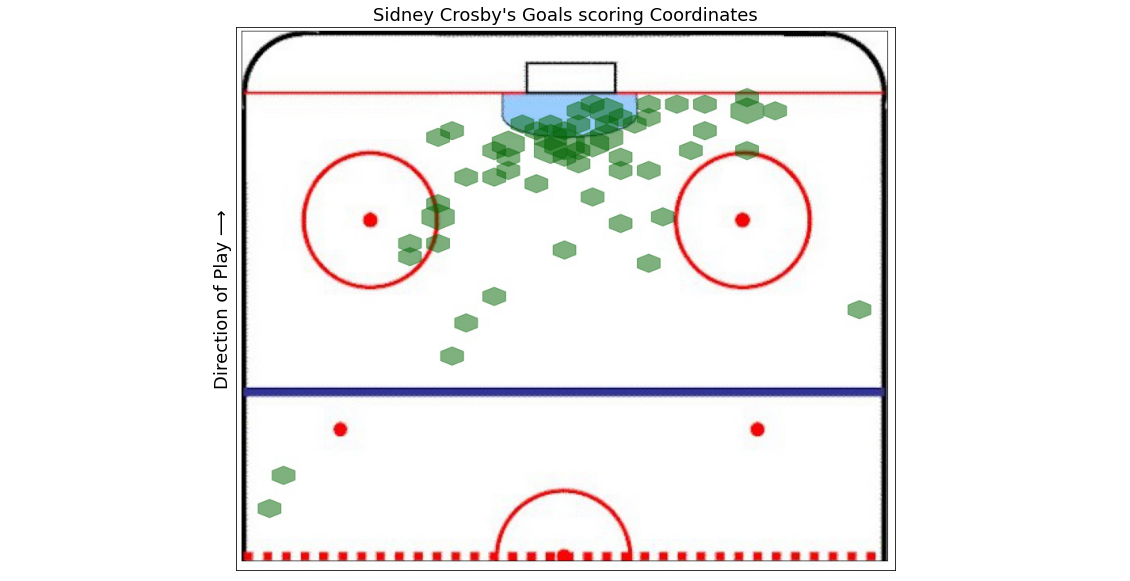

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

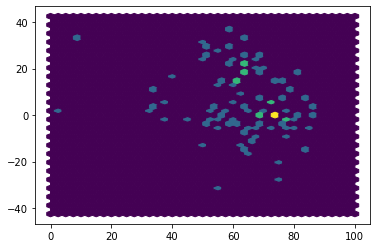

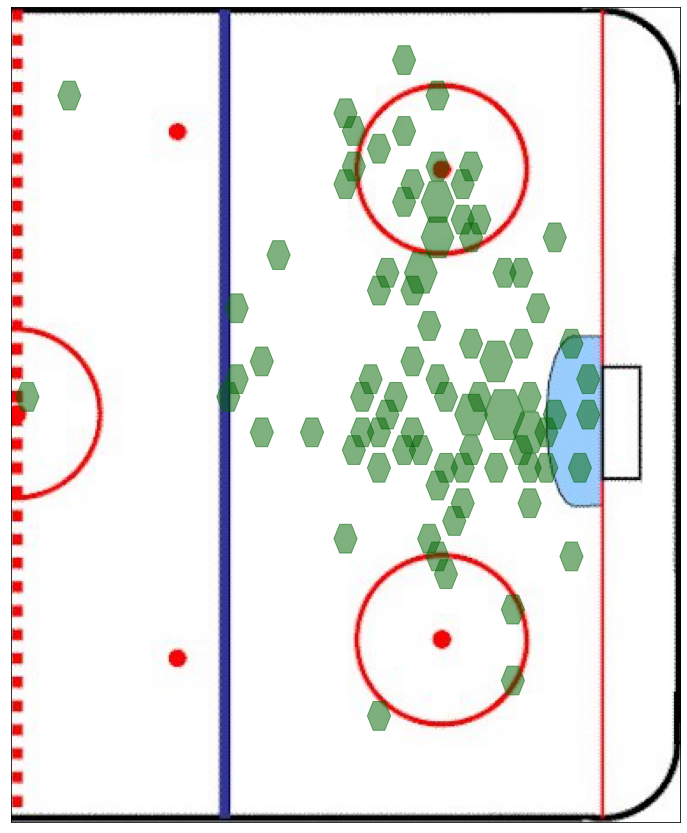

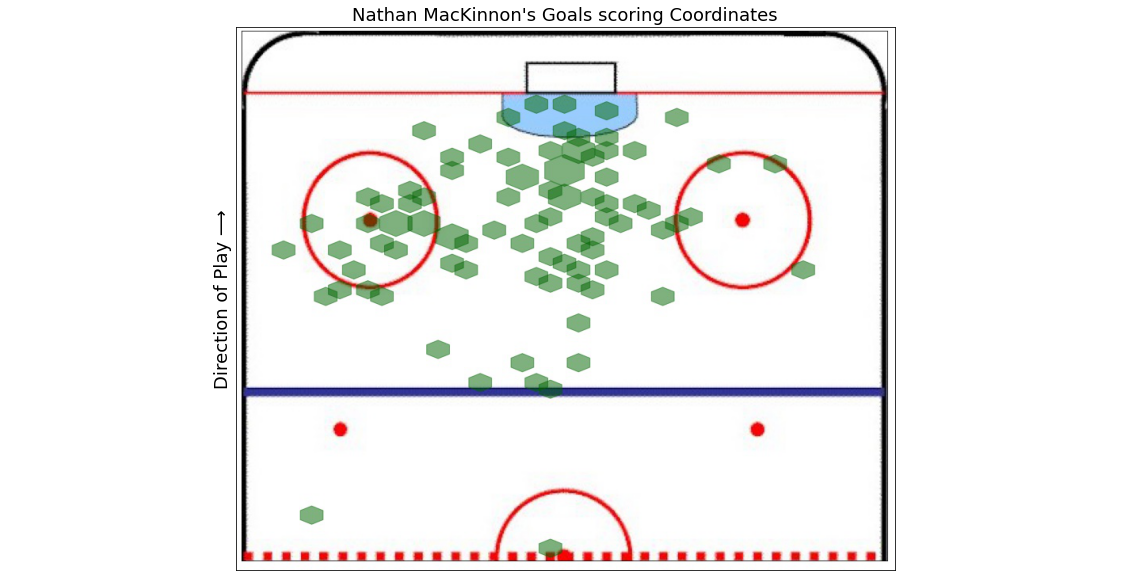

<Figure size 432x288 with 0 Axes>

In [13]:
for idx, player_df in enumerate(player_df_list):

    figure = plt.figure()
    goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(None, player_df);
    plot_shots_goals_on_rink(None, None, goals_hexbin_offsets, goals_hexbin_values, False)
    plot_shots_and_goals_comparison('Attack_Shots.jpeg', 'Attack_Goals.jpeg', \
                                    plot_title_shots = '', \
                                    plot_title_goals = top_4_players[idx] + "'s Goals scoring Coordinates", \
                                    plot_shots = False)
    plt.clf()